In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import *
import random

Given that the world is set to be 200 centimeters in length, and the landmarks are specified to be 10 centimeters in both the x and y axes apart from the edges

In [26]:
landmarks = [[10,10], [190,10], [10,190], [190,190]]
world = 200.0

The below splits the landmark coordinates into two seperate lists holding the x and y coordinates respectively. A scatter plot is plotted with the world and the landmarks, in order to aid in visualising the area we are working with

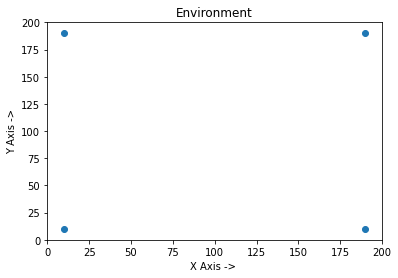

In [3]:
#---------Set Up Only For Plot-------------
#---------To Be Removed Just Testing--------
landmarksX = np.array([10, 190, 10, 190])
landmarksY = np.array([10, 10, 190, 190])
#------------------------------------------
plt.title("Environment")
plt.xlabel("X Axis -> ")
plt.ylabel("Y Axis ->")
plt.xlim([0,200])
plt.ylim([0,200])
plt.scatter(landmarksX, landmarksY)
plt.show()

The Gaussian Probability is calculated with Mu being the distance to the landmark, sigma being the standard deviation and x being the landmark measured by the robot

In [4]:
def Gaussian(mu, sigma, x):
    
    return exp(- ((mu - x) ** 2) / (sigma ** 2) / 2.0) / sqrt(2.0 * pi * (sigma ** 2))

In [17]:
class Robot:
    def __init__(self):
        #Spawn Points and Location
        self.x = random.random() * world
        self.y = random.random() * world
        self.orientation = random.random() * 2.0 * pi
        
        self.max_steering = pi/4
        self.bearing_noise = radians(0.1)
        self.steering_noise = radians(0.1)
        self.distance_noise = 5
        
    #In other words the Robot is Initialized by setting up all the according weights, coordinates and noises
    def set(self, spawnX, spawnY, orient):
        if spawnX < 0 or spawnX >= world:
            raise ValueError('[ERR] X Coordinate Out Of Bounds')
            
        if spawnY < 0 or spawnY >= world:
            raise ValueError('[ERR] Y Coordinate Out Of Bounds')
            
        if orient < 0 or orient >= 2*pi:
            raise ValueError('[ERR] Orientation Has To Be in Range 0 -> PI/4')
            
        self.x = spawnX
        self.y = spawnY
        self.orientation = orient
        
    def noise(self, bearing, steering, distance):
        self.bearing_noise = float(bearing)
        self.steering_noise = float(steering)
        self.distance_noise = float(distance)
     
    #The environment is sensed by the robot by receiving the distance to the four landmarks. 
    #Naturally, considering the sensing noise, this is filtered out using a gaussian with an added zero mean.
    #An added zero mean, means that the chance that the distance is too short or too long is covered by the gaussian filter
    
    def sense(self):
        Z = []
        for i in range(len(landmarks)):
            distribution = sqrt((self.x - landmarks[i][0]) ** 2 + (self.y - landmarks[i][1]) ** 2)
            distribution += random.gauss(0, self.bearing_noise)
            Z.append(distribution)
            
        return Z
            
    def move(self, turn, forward):
        
        if forward == 0:
            raise ValueError('[ERR] Cannot Move Backwards')
        
        #Turning with added randomness to the turn movement
        orientation = self.orientation + float(turn) + random.gauss(0, self.steering_noise)
        orientation %= 2*pi
        
        #Moving with added randomness to the movement
        dist = float(forward) + random.gauss(0.0, self.bearing_noise)
        x = self.x + (cos(orientation) * dist)
        y = self.y + (sin(orientation) * dist)
        
        #Cyclic Truncate 
        x %= world   
        y %= world
        
        #Set Particle
        res = Robot()
        res.set(x, y, orientation)
        res.noise(self.bearing_noise, self.steering_noise, self.distance_noise)
        return res
        
    #Considering the Particle Filter, the below function assigns a weight for each particle considering the current measurement
    #The Gaussian Probability Filter is used to measure the difference in distance from the predicted to the actual measurements
    #The Gaussian acts accordingly with the distance noise in order to avoid division by zero 
    
    def measurement_prob(self, measurement):
        
        prob = 1.0
        
        for i in range(len(landmarks)):
            dist = sqrt((self.x - landmarks[i][0]) ** 2 + (self.y - landmarks[i][1]) ** 2)
            prob *= Gaussian(dist, self.distance_noise, measurement[i])
            
        return prob
    
    def __repr__(self):
        return '[x=%.6s y=%.6s orient=%.6s]' % (str(self.x), str(self.y), str(self.orientation))

Creating a Robot and setting the noise. Afterwards the move and sense functions are tested by trying out random movements and sensing them.

In [18]:
robot = Robot()
robot.noise(0.1, 0.1, 5)

robot.set(30.0, 50.0, pi/6)
robot = robot.move(pi/6, 15.0)
print(robot)
print(robot.sense())

[x=37.881 y=62.787 orient=1.0184]
[59.82490236508767, 161.17443353576772, 130.18156975656632, 198.3466649194554]


In [19]:
n = 500 #Number of Particles
p = [] #List for the Particles

for i in range(n):
    newrobot = Robot()
    newrobot.noise(0.1, 0.1, 5)
    p.append(newrobot)
    
steps = 50 #Steps for the Particles 

for y in range(steps):
    
    #Moving the Robot and Sensing the Environment
    robot = robot.move(0.1, 5.0)
    z = robot.sense()
    
    #Simulating a Movement for each particle
    p2 = []
    
    for i in range(n):
        p2.append(p[i].move(0.1, 5.0))
        
    p = p2
    
w = []

#Generating weights for the particles in the Particle Filter considering the measurements
for i in range(n):
    w.append(p[i].measurement_prob(z))

## Resampling 

Resampling is essential for a Particle Filter. In the original Particle Filter, the particles do not have the same lifespan, this is because of the survival rate being dependent on the weight assigned to the particle. After resampling, the large weighted particles are most likely to carry on, whilst the small weighted particles tend to die out. This implies that particles which are very consistent with the measurement sensor stay in the filter with a higher probabilty, and the opposite for the lower importance weight particles.

In [20]:
p3 = []
index = int(random.random()*n)
beta = 0.0
mw = max(w)

for i in range(n):
    beta += random.random() *2.0 * mw
    
    while beta == w[index]:
        beta -= w[index]
        index = (index + 1)%n
        
    p3.append(p[index])

#A Set of Co-Located Particles 
p = p3

In order to the determine the quality of the solution the Particle Filter provides, the below function is used. The Evalution function takes the current robot and the particle set as parameters in order to compute the average error for each particle relative to the robot's current angle. This function is called at the end of each iteration.

In [21]:
def Evaluation(r, particle):
    
    sum = 0.0
    
    for i in range(len(particle)):
        
        dx = (particle[i].x - r.x + (world/2.0)) % \
             world - (world/2.0)
        dy = (particle[i].y - r.y + (world/2.0)) % \
             world - (world/2.0)
        err = sqrt(dx**2 + dy**2)
        sum += err
        
    return sum/float(len(particle))
 
p = p3
print('Step = ', steps, 'Evaluation = ', Evaluation(robot, p))

Step =  50 Evaluation =  90.4718968351221


In [42]:
def Visualization(robot, step, particles, pr, weights):
    
    plt.figure("Robot in World", figsize = (200, 200))
    plt.title("Particle Filter with Step: " + str(step))
    
    grid = [0, world, 0, world]
    plt.axis(grid)
    plt.grid(b = True, which = 'major', color = '0,75', linestyle = '--')
    plt.xticks([i for i in range(0, int(world), 5)])
    plt.yticks([i for i in range(0, int(world), 5)])
    
    #Drawing Particles 
    for a in range(len(particles)):
        
        #Particle
        particle = plt.Circle((particles[a].x, particles[a].y), 1., facecolor='#66ff66', edgecolor='#009900', alpha=0.5)
        plt.gca().add_patch(particle)
        
        #Particle Orientation
        arrow = plt.Arrow(particles[a].x, particles[a].y, 2*cos(particles[a].orientation), 2*sin(particles[a].orientation), alpha = 1., facecolor='#ffb266', edgecolor='#994c00')
        plt.gca().add_patch(arrow)
        
    #Resampled Particles
    for a in range(len(pr)):
        
        #Particle
        circle = plt.Circle((pr[a].x, pr[a].y), 1., facecolor='#66ff66', edgecolor='#009900', alpha=0.5)
        plt.gca().add_patch(circle)
 
        #Particle Orientation
        arrow = plt.Arrow(pr[a].x, pr[a].y, 2*cos(pr[a].orientation), 2*sin(pr[a].orientation), alpha=1., facecolor='#006600', edgecolor='#006600')
        plt.gca().add_patch(arrow)
 
        
    #Landmarks
    for b in landmarks:
            
        landmark = plt.Circle((b[0], b[1]), 1.,  facecolor='#cc0000', edgecolor='#330000')
        plt.gca().add_patch(landmark)
     
    #Robot Location
    circle = plt.Circle((robot.x, robot.y), 1., facecolor='#6666ff', edgecolor='#0000cc')
    plt.gca().add_patch(circle)
    
    #Robot Orientation
    arrow = plt.Arrow(robot.x, robot.y, 2*cos(robot.orientation), 2*sin(robot.orientation), alpha=0.5, facecolor='#000000', edgecolor='#000000')
    plt.gca().add_patch(arrow)
    
    plt.savefig("figure_" + str(step) + ".png")
    plt.close()
    
    
Visualization(robot, steps, p , p3, w)

ValueError: Invalid RGBA argument: '0,75'

ValueError: Invalid RGBA argument: '0,75'

<Figure size 14400x14400 with 1 Axes>